# Potential flow and Joukowski transform

Philipp Schlatter, 2024 (adapted from Barba et al. Aeropython)

Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/kutta-joukowski.ipynb

### Preliminaries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures
  !pip install -q ipympl ipython ipywidgets
  from google.colab import output
  output.enable_custom_widget_manager()

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

### Parameters

In [3]:
x_center, y_center = -0.0, 0.0          # plate
#x_center, y_center = -0.2, 0.2          # cambered airfoil
x_center,y_center = -0.2,0.             # symmetric profile

u_inf = 1             # free-stream speed
alpha = 10*(np.pi/180)  # angle of attack

In [4]:
R = np.sqrt((1-x_center)**2+y_center**2)   # circle needs to go through (1,0)
M = (R**2)*2*np.pi*u_inf  # doublet for circle with radius R
Gamma = -4*np.pi*R*u_inf*np.sin(alpha + np.arcsin(y_center/R))  # Kutta condition for AoA alpha

### Definition of the mesh

In [5]:
class Cartesian:
    def __init__(self,N,x_start,x_end,y_start,y_end):
        self.X, self.Y = np.meshgrid(np.linspace(x_start, x_end, N), np.linspace(y_start, y_end, N))
        self.type = "Cartesian"
        
class Polar:
    def __init__(self,N,r_start,r_end):
        xx,yy = np.meshgrid(np.linspace(r_start,r_end,N),np.linspace(0,2*np.pi,N,endpoint=True))
        self.X, self.Y = xx*np.cos(yy)+x_center,xx*np.sin(yy)+y_center
        self.type = "Polar"
        
class Velocity:
    def __init__(self,mesh):
        self.u = mesh.X*0
        self.v = mesh.X*0
        self.p = mesh.X*0
        
    def comp_p(self,u_ref):
        self.p = 2*(0.5*u_ref**2-0.5*(self.u**2 + self.v**2))

In [6]:
# for a Kutta-Joukoswski airfoil, we choose a polar mesh
mesh = Polar(100,R,8)

### Elementary flow solutions

In [7]:
class Doublet:
    # strength M
    def __init__(self, strength, x, y):
        self.strength = strength
        self.x, self.y = x, y

    def vel(self, mesh):
        u = (-self.strength / (2 * np.pi) *
             ((mesh.X - self.x)**2 - (mesh.Y - self.y)**2) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        v = (-self.strength / (2 * np.pi) *
             2 * (mesh.X - self.x) * (mesh.Y - self.y) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        return u, v

    def psi(self, mesh):
        psi = -(self.strength / (2 * np.pi) *
               (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        return psi

In [8]:
class Vortex:
    def __init__(self, strength, x, y):
        self.strength = strength  # Gamma
        self.x, self.y = x, y

    def vel(self, mesh):
        u = -self.strength / (2 * np.pi) * (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        v = +self.strength / (2 * np.pi) * (mesh.X - self.x) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return u, v

    def psi(self, mesh):
        psi =  -self.strength / ( 4*np.pi) * np.log((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return psi

In [9]:
class Freestream:
    def __init__(self, strength, alpha):
        self.strength = strength
        self.alpha = alpha
        
    def vel(self, mesh):
        u = mesh.X*0 + self.strength*np.cos(self.alpha) 
        v = mesh.X*0 + self.strength*np.sin(self.alpha) 
        return u, v
            
    def psi(self, mesh):
        psi = self.strength*(-mesh.X*np.sin(self.alpha) + mesh.Y*np.cos(self.alpha))
        return psi

### Rotating cylinder

In [10]:
# Flow around a cylinder
fst = Freestream(u_inf,0)
u1,v1 = fst.vel(mesh)
psi1 = fst.psi(mesh)

doublet = Doublet(strength=M, x=x_center,y=y_center)
u2, v2 = doublet.vel(mesh)
psi2 = doublet.psi(mesh)

vortex = Vortex(strength=Gamma, x=x_center,y=y_center)
u3, v3 = vortex.vel(mesh)
psi3 = vortex.psi(mesh)

U = Velocity(mesh)
U.u = u1+u2+u3
U.v = v1+v2+v3
psi = psi1+psi2+psi3

# R = np.sqrt(M/(2*np.pi*u_inf))

theta = np.linspace(0.0, 2 * np.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))

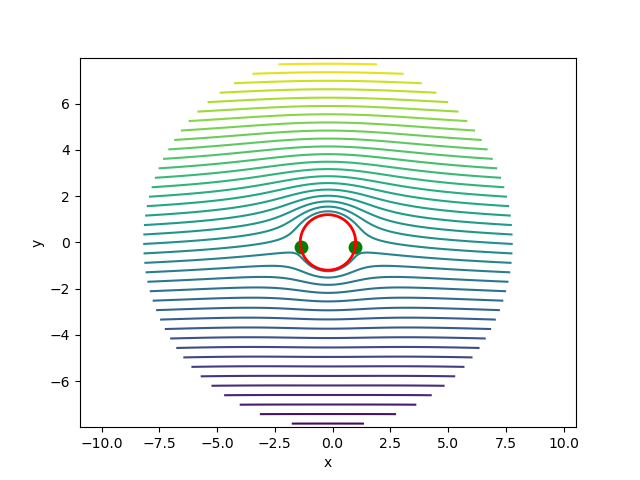

In [11]:
# streamfunction and stagnation points
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.contour(mesh.X, mesh.Y, psi,40)
plt.plot(x_cylinder, y_cylinder, color='r', linestyle='-', linewidth=2)
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*mt.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*mt.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');
plt.show()

C:\Users\pschl\AppData\Local\Temp\ipykernel_3488\3336289744.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmin=-4,cmap='jet')


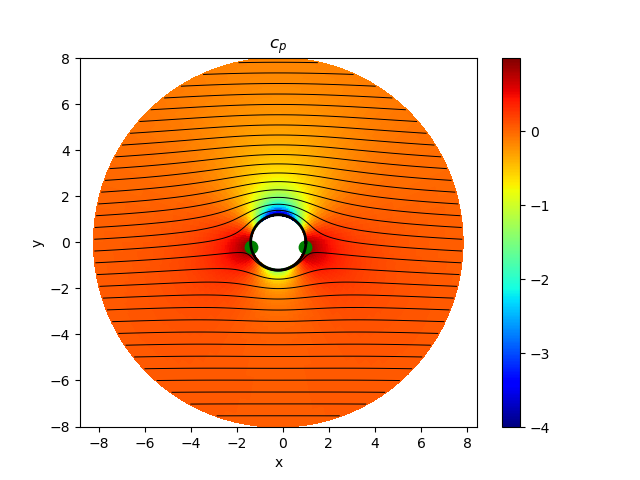

In [12]:
U.comp_p(u_inf)
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmin=-4,cmap='jet')
plt.axis('equal')
plt.colorbar()
plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)

plt.contour(mesh.X, mesh.Y, psi, levels=np.arange(-40,40,0.5),linewidths=0.7,linestyles='-',colors='k')
plt.title('$c_p$')
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');

plt.show()

### Joukowski transform

In [13]:
xi = (mesh.X + 1j*mesh.Y - (x_center+1j*y_center))*np.exp(1j*alpha) +  (x_center+1j*y_center)
xi_cyl = (x_cylinder + 1j*y_cylinder - (x_center+1j*y_center))*np.exp(1j*alpha)+  (x_center+1j*y_center)

In [14]:
Z = (1/xi + xi)*np.exp(-1j*alpha)
Z_cyl = (1/xi_cyl + xi_cyl)*np.exp(-1j*alpha)

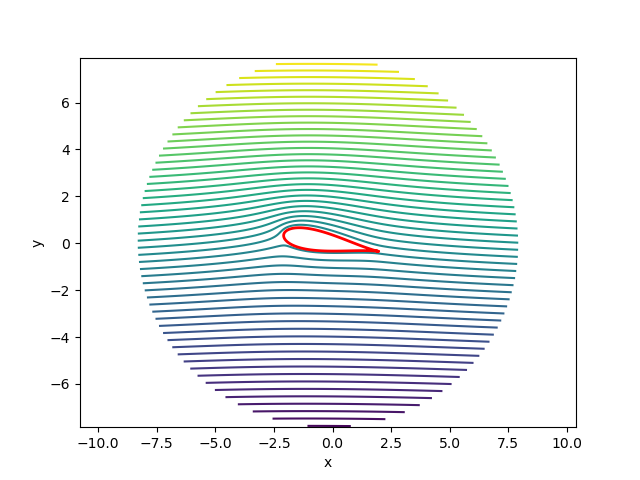

In [15]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.contour(np.real(Z), np.imag(Z), psi,60)
plt.plot(np.real(Z_cyl), np.imag(Z_cyl), color='r', linestyle='-', linewidth=2)
plt.show()

C:\Users\pschl\AppData\Local\Temp\ipykernel_3488\97360101.py:4: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(np.real(Z),np.imag(Z), U.p/u_inf**2,vmin=-2,cmap='jet')


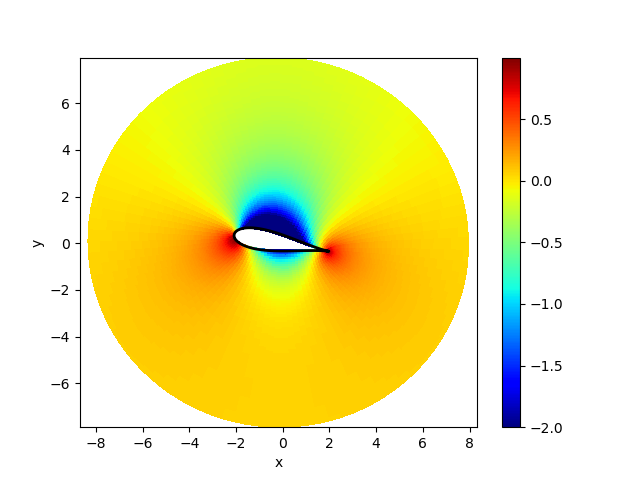

In [16]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.pcolor(np.real(Z),np.imag(Z), U.p/u_inf**2,vmin=-2,cmap='jet')
plt.axis('equal')
plt.colorbar()
plt.plot(np.real(Z_cyl), np.imag(Z_cyl), color='k', linestyle='-', linewidth=2)
plt.show()

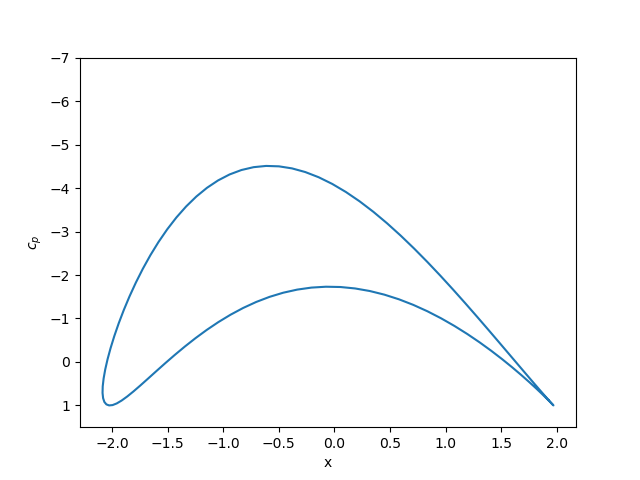

In [17]:
plt.figure()
plt.plot(np.real(Z[:,0]),U.p[:,0])
plt.xlabel('x')
plt.ylabel(r'$c_p$')
plt.ylim(1.5,-7)
plt.show()

Lift per unit span: $L'=L/b = -\rho \Gamma U_\infty$

Kutta condition: $\Gamma = -4 \pi R U_\infty \sin(\alpha+\arcsin(y_\mathrm{center}/R))$

Lift coefficient: $C_L = L/(\frac12 \rho U_\infty^2 c b) = -2  \Gamma / (U_\infty c) =  8\pi\sin(\alpha+\arcsin(y_\mathrm{center}/R)) (R/c) \approx 2 \pi \sin(\alpha)$. This is exact for a mapping into a flat plate.

Lift slope: $\frac{\mathrm d C_L}{\mathrm d \alpha} = 2\pi$ (at $\alpha-\alpha_0$)

Zero-lift angle $\sin(\alpha_0) = -\frac{y_\mathrm{center}}{R}$

In [18]:
# Lift coefficient C_L from Kutta-Joukowski theorem
alpha0 = -np.arcsin(y_center/R)   # zero-lift angle for cambered profiles
c = 4  # approximation for Joukowski profiles (a bit longer than 4)
cl=-2*Gamma/u_inf/c
print('lift coefficient: CL = {:0.5f}'.format(cl))
print('lift slope: dCL/dalpha = {:0.5f}'.format(cl/(alpha-alpha0)))

lift coefficient: CL = 1.30928
lift slope: dCL/dalpha = 7.50160


In [19]:
# analytical value for a flat plate
cl_th=2*np.pi*np.sin(alpha-alpha0)
print('lift coefficient: CL = {:0.5f}'.format(cl_th))
print('lift slope: dCL/dalpha = {:0.5f}'.format(2*np.pi))

lift coefficient: CL = 1.09106
lift slope: dCL/dalpha = 6.28319


In [20]:
# radius
R

1.2

In [21]:
# zero lift angle
alpha0

-0.0

In [22]:
# measured chord length
np.max(np.real(Z[:,0]))-np.min(np.real(Z[:,0]))/np.cos(alpha)

4.086599876007775